#### Необходимые импорты

In [ ]:
# !pip install -r requirements.txt

In [ ]:
# для визуализации
import plotly.express as px
import matplotlib.pyplot as plt

import json
import pandas as pd
import numpy as np
from collections import Counter
from typing import List
from wordcloud import WordCloud
import nltk

# для предобработки текстов
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from pymorphy2 import MorphAnalyzer

# для тематического моделирования
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from bertopic import BERTopic

# для суммаризации
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.summarizers.luhn import LuhnSummarizer

from sklearn.manifold import TSNE

# для сохранения моделей
import pickle

In [ ]:
# !pip list

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

#### Этапы решения задач

1. Предобработка текстов
2. Токенизация текстов
3. Векторизация токенизированных текстов
4. Тематическое моделирование
5. Автоматическая суммаризация тем
6. Создание системы для обработки новых цитат

#### Загрузка данных

In [ ]:
with open('cintra_phoenix_oils_hr_mgck_feather.json') as f:
    data = json.load(f)

В первом приближении нельзя не заметить огромное количество опечаток в словах из цитат, повторение букв ("райооне", "сттеклянной" и т.д.), а также использование цифр вместо букв ("ко4урно", "ска3ть") или английских букв ("супеRRR", "ночi"). Возможно, это специфика языка во Вселенной, но я все-таки решила воспринимать это именно как ошибки и, чтобы получить качественные результаты выделения тематик при помощи моделей, в первую очередь обработать тексты цитат и избавиться от "мусора".

In [ ]:
df = pd.DataFrame(data)
df.head()

,id,quote
0,0,«У ннас среди ночi в райооне 55 часов упала по...
1,1,Программы повышения квалификации через гильдию...
2,2,"""Мурр... Новиград - город контрастов, да. Но в..."
3,3,"Типа, вот уже полгода, как мы ждем установки э..."
4,4,"""Теперь всьё так просто! Раньше бумажки летали..."


Чтобы при обработке текстов не потерять важную информацию, содержащуюся в аббревиатурах, сначала заменю аббревиатуры на их значения.

In [ ]:
f = open("abbreviations.txt", "r")
abbr_dict = dict()
for x in f:
    abbr, full_form = x.split('-')[0].strip(), x.split('-')[1].strip()
    abbr_dict[abbr] = full_form

abbr_dict

{'СУОЧ': 'Система управления операционными чарами',
 'ЗМС': 'Зачарованная маслостанция',
 'НСС': 'Назаирская система слива',
 'ЛДС': 'Лекарский договор страхования',
 'ЦИСТ': 'Цинтрийский стандарт',
 'СОКГ': 'Система оплаты карточкой гильдии'}

In [ ]:
def replace_abbreviations(quote: str, abbr_dict: dict) -> str:
    for abbr, full_form in abbr_dict.items():
        quote = quote.replace(abbr, full_form)
    return quote

In [ ]:
df['quote'] = df.apply(lambda x: replace_abbreviations(x['quote'], abbr_dict), axis=1)

#### EDA исходных данных

##### Распределение длин цитат

In [ ]:
df['length'] = df['quote'].apply(lambda x: len(x.split()))

In [ ]:
fig = px.histogram(df, x='length', color_discrete_sequence=['#7BECF7'], marginal='box', nbins=40, title="Распределение длин цитат")

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    width=1300,
    height=500,
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF')
)

fig.update_xaxes(title_text='Длина цитаты', row=1, col=1)
fig.update_yaxes(title_text='Частота', row=1, col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')

fig.show()

В связи с невозможностью отображения графиков plotly express в GitHub, здесь и далее (там, где это возможно) будут прикреплены статичные изображения.

![Распределение длин цитат](figures/length_distribution.png)

Можно заметить, что большинство цитат представляют собой короткие тексты (75% имеют длину 50 и меньше). Модальный интервал значений длины цитат — 30-39 слов.

In [ ]:
df[df['length'] == 4]['quote'].values[0]
# самая короткая цитата

'В "ФФениксе"  ллучше было. \n'

In [ ]:
df[df['length'] == 365]['quote'].values[0]
# самая длинная цитата

'“алхимическое образование, минимальная база. Иначе человеку совсем тяжело в такую работу вникнуть, в чём суть опытов, что опасно делать, что нельзя. Одно дело, когда люди приходят, пусть они даже со студенческой скамьи, они алхимики, они хотя бы представляют, что это такое  Минимальная база, это корочка подмастерье-алхимика (вуз, суз – неважно), с этим уже можно работать дальше + желание, стремление работать (человеческие качества)”   “Хотелось бы с профильным образованием, не зная основ хотя бы просто химии, сложно вникнуть: среднетехническое образование по профилю Подмастерье-алхимик хим. анализа; высшее образование - по любой химической специальности; профильное образование по специальности Знахарство. В самой химии ключевые темы: например, изучают сейчас с сотрудниками из техникума с азов. Она сейчас проводит обучение и рассказывает основы из 8 класса общего образования. Нужно хорошо понимать, что ты делаешь, понимать, какой результат получен. Нельзя просто заполнить бумажки, пере

In [ ]:
df = df.drop(['length'], axis=1)

##### Общее количество слов в коллекции цитат

In [ ]:
# функция для создания словаря слов
def vocabulary(quotes, stopwords=None):
    if stopwords is None:
        words = []
        for quote in quotes:
            # минимальная чистка данных - приведение слов к нижнему регистру и удаление мусорных символов
            words += word_tokenize(re.sub('[^а-яa-z0-9 ]', '', quote.lower()))

    # уберем стоп-слова
    else:
        words = []
        for quote in quotes:
            words += [word for word in word_tokenize(re.sub('[^а-яa-z0-9 ]', '', quote.lower())) if word not in stopwords]

    return words

In [ ]:
words = set(vocabulary(df['quote']))
len(words)

10393

##### Наиболее популярные слова

In [ ]:
counter = Counter(vocabulary(df['quote']))
most_common_words = counter.most_common(20)  # топ-20 слов
print(most_common_words)

# видно, что наиболее популярными словами являются стоп-слова

[('в', 1097), ('не', 870), ('и', 829), ('что', 726), ('на', 645), ('с', 617), ('как', 591), ('а', 518), ('так', 517), ('у', 477), ('я', 440), ('это', 433), ('но', 408), ('вот', 355), ('вс', 333), ('бы', 282), ('мы', 260), ('все', 242), ('по', 224), ('нас', 219)]


In [ ]:
# теперь посмотрим на наиболее популярные слова без учета стоп-слов
stop_words = stopwords.words('russian')

# в списке стоп-слов из библиотеки нет некоторых стоп-слов слов, а в цитатах они встречаются довольно часто,
# поэтому добавлю эти слова в список
stop_words += ['всё', 'это', 'свой', 'весь', 'вроде', 'ещё', 'наш']

counter = Counter(vocabulary(df['quote'], stopwords=stop_words))
most_common_words = counter.most_common(20)  # топ-20 слов
print(most_common_words)

# здесь уже появляются слова, несущие какой-то смысл (их немного)

[('вс', 333), ('просто', 217), ('дон', 195), ('цмф', 191), ('маслостанция', 180), ('зачарованная', 177), ('сказать', 177), ('понимаешь', 140), ('както', 132), ('очень', 106), ('масла', 102), ('работать', 96), ('цк', 85), ('например', 82), ('время', 76), ('люди', 75), ('масло', 74), ('чтото', 72), ('вообще', 65), ('говорят', 65)]


In [ ]:
df_most_common = pd.DataFrame(most_common_words, columns=['Слово', 'Частота'])

fig = px.bar(df_most_common, y='Слово', x='Частота', color_discrete_sequence=['#7BECF7'], orientation='h', title='Топ-20 слов')

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    width=1300,
    height=500,
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF')
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white')

fig.show()

![Топ-20 слов](figures/top20.png)

Получившаяся диаграмма показывает, что проведенной предобработки текстовых данных пока недостаточно, так как наиболее часто встречающиеся слова выглядят не слишком интерпретируемыми. Далее цитаты будут обработаны более качественно и еще раз будут определены наиболее популярные слова.

##### Облако слов

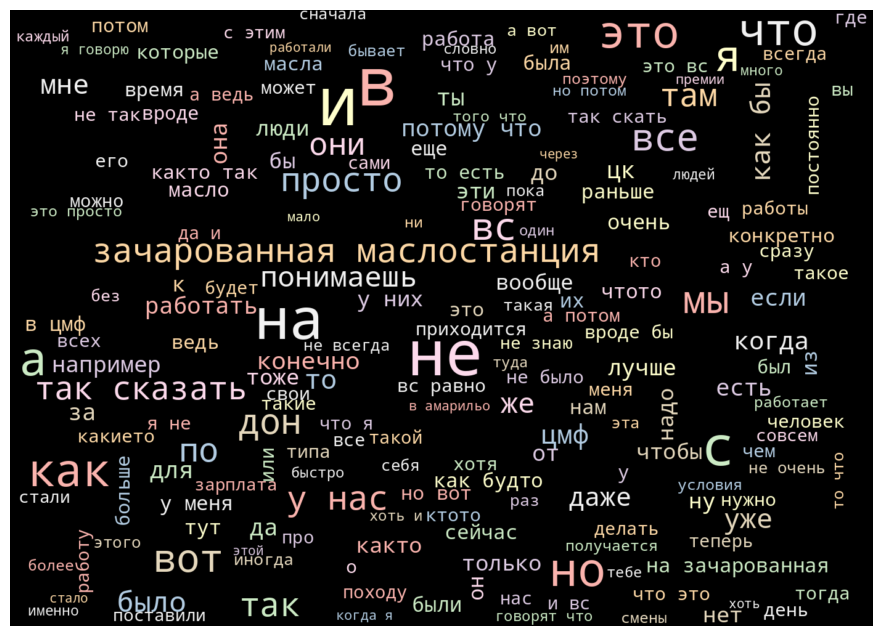

In [ ]:
text = ' '.join(df['quote'].apply(lambda x: re.sub('[^а-яa-z0-9 ]', '', x.lower())))
wordcloud = WordCloud(width=1400, height=1000, background_color ='black', colormap='Pastel1', max_font_size=110, collocations=True).generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

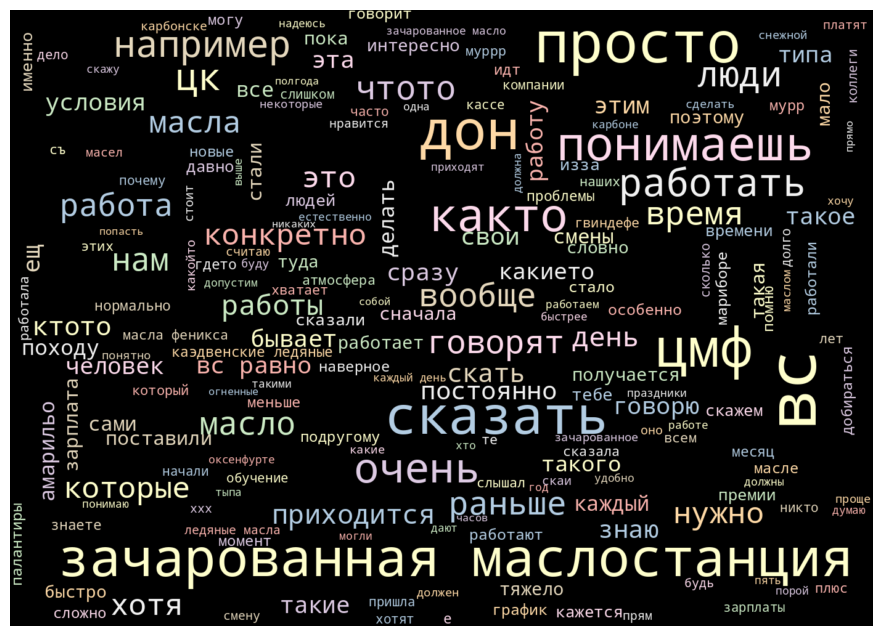

In [ ]:
# без стоп-слов
text = ' '.join(df['quote'].apply(lambda x: re.sub('[^а-яa-z0-9 ]', '', x.lower())))
wordcloud = WordCloud(width=1400, height=1000, background_color ='black', colormap='Pastel1', stopwords = stop_words, max_font_size=110, collocations=True).generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Облако слов позволяет посмотреть на данные в разрезе относительной важности различных слов в тексте: чем крупнее слово в облаке, тем важнее оно (крупные слова могут указывать на ключевые темы или идеи, либо на стоп-слова).

Наиболее популярные слова/биграммы в наших цитатах — "зачарованная маслостанция", "цмф" говорят о компании и ее деятельности, "сказать", "просто", "понимаешь" не несут в себе большого смысла.

Несмотря на это, другие слова из облака (менее популярные) позволяют исходя из анализа облака выделить некоторые темы: например, условия труда (график работы, зарплата и премии), праздники, рабочая атмосфера и взаимоотношения с коллегами, обучение и адаптация новых сотрудников, удобство добираться до работы.

Также видим слова-паразиты — "дон", "цк", "муррр", "тыпа", "походу", "типа", "так скать", "но вот", "как бы". Они характеризуют работников низкого и среднего уровня квалификации (например, работники ЗМС). Слова-паразиты могут дать представление о культурном и региональном бэкграунде сотрудников, указать на неуверенность/недовольство сотрудников относительно обсуждаемых вопросов.

In [ ]:
# print(df[df['quote'].str.contains('добираться')]['quote'].values)

#### Создание кастомного токенизатора для обработки исходных цитат, а именно:
1. приводит все слова цитаты к нижнему регистру
2. удаляет все мусорные слова, в т.ч. пунктуацию
3. разбивает цитату на токены (слова)
4. убирает слова-числа
5. исправляет опечатки в словах
6. удаляет цифры из слов
7. проводит лемматизацию слов
8. убирает стоп-слова

Ключевой задачей кастомного токенизатора является нормализация текста и избавление его от мусора с последующей токенизацией.

Поскольку тексты цитат содержат очень много ошибок, без их исправления тут не обойтись, потому что эти ошибки вносят очень много шума в данные и могут негативно сказаться на результатах обучения моделей. Использовала для этого SpellChecker.

Цифры решила удалять из слов уже после исправления опечаток, т.к. некоторые цифры заменяют буквы в словах, и SpellChecker лучше понимает, как исправить такое слово с цифрой, чем без нее. Например, слово "ска3ть" правильно распознается только с цифрой.

Лемматизация — процесс приведения слова к его нормальной форме (лемме):
- для существительных — именительный падеж, единственное число;
- для прилагательных — именительный падеж, единственное число, мужской род;
- для глаголов, причастий, деепричастий — глагол в инфинитиве.

В данной задаче решила использовать именно лемматизацию, а не стемминг, т.к.

1) лемматизация позволяет рассматривать как отдельный признак каждое слово, а не каждую его отдельную форму,

2) некоторые стоп-слова стоят только в начальной форме, и без лемматизации выкидывается только она,

3) стемминг более "грубо" обрубает слова, убирая аффиксы (окончания и суффиксы),

4) а также результаты лемматизации более интерпретируемые, что важно для оценки качества тематического моделирования и выделения ключевых слов.  

Стоп-слова — это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, т.е. играют роль шума, поэтому их убираю. Пунктуация (и другой мусор, а также числа) также не несет в себе никакого смысла (за исключением некоторых случаев по типу "казнить нельзя помиловать" и смайликов, которые могут говорить об эмоциональном окрасе фразы, однако это свойство более актуально, например, для задачи анализа тональности текста и специфических текстов, например, твитов).

In [ ]:
stop_words = stopwords.words('russian')
spell = SpellChecker(language='ru')
pymorphy2_analyzer = MorphAnalyzer()

In [ ]:
# в списке стоп-слов из библиотеки нет некоторых стоп-слов слов, а в цитатах они встречаются довольно часто,
# поэтому добавлю эти слова в список
stop_words += ['всё', 'это', 'свой', 'весь', 'вроде', 'ещё', 'наш']

Вспомогательные функции

In [ ]:
def word_is_digit(word: str) -> bool:
    # Проверка, содержит ли слово только цифры
    return word.isdigit()

def contains_digit(word: str) -> bool:
    # Проверка, содержит ли слово цифры
    return any(map(str.isdigit, word))

def delete_digits_in_word(word: str) -> str:
    # Удаление цифр внутри слова либо по краям слова
    if contains_digit(word) and not word_is_digit(word):
      filtered_characters = filter(lambda x: not x.isdigit(), word)
      return ''.join(filtered_characters)
    else:
      return word

def correct_spelling(word: str) -> str:
    # Исправление опечаток в слове
    corrected_word = spell.correction(word)
    return corrected_word if corrected_word else word

Кастомный токенизатор

In [ ]:
def custom_tokenizer(s: str) -> List[str]:
    # Кастомный токенизатор

    # приведение строки к нижнему регистру
    s = s.lower()
    # удаление всех мусорных символов, в т.ч. пунктуации
    s = re.sub('[^а-яa-z0-9 ]', '', s)
    # токенизация строки на слова
    s = word_tokenize(s)

    mask = list(map(word_is_digit, s))
    # маска, определяющая слова из списка, состоящие только из цифр
    s = np.array(s)[np.where(np.array(mask)==0)].tolist()
    # оставляю список из слов, не удовлетворяющих условию (маске), т.е. слов не состоящих только из цифр

    # исправление опечаток в словах
    s = [correct_spelling(word) for word in s]

    # удаление цифр внутри слов
    s = [delete_digits_in_word(word) for word in s]

    # лемматизация слов
    s = [pymorphy2_analyzer.parse(word)[0].normal_form for word in s]

    # проверка, является ли слово стоп-словом
    def is_a_stop_word(w: str):
      return w in stop_words

    stop_word_mask = list(map(is_a_stop_word, s))
    # применяю маску ко всему списку, чтобы определить, какие слова из списка являются стоп-словами
    s = np.array(s)[np.where(np.array(stop_word_mask)==0)].tolist()
    # оставляю только слова, не удовлетворяющие условию (маске), т.е. те, которые не являются стоп-словами
    return s

Применение кастомного токенизатора к первым двум цитатам для просмотра результата

In [ ]:
print(df['quote'][:2].apply(custom_tokenizer).tolist())

[['среди', 'ночь', 'район', 'час', 'упасть', 'пол', 'вода', 'сттеклять', 'тара', 'тобыть', 'посреди', 'луна', 'стекло', 'утро', 'кстати', 'первый', 'падать', 'като', 'неправильно', 'рассчитывать', 'должный', 'заставлять', 'определённо', 'картинка', 'пара', 'грохаться', 'полка', 'буттылка'], ['программа', 'повышение', 'квалификация', 'гильдия', 'хитрый', 'хитрый', 'хотеть', 'попытаться', 'предпочтение', 'направление', 'гильдия', 'гильдия', 'толкать', 'нужно', 'сотрудник', 'белый', 'змея', 'например', 'программа', 'гиббс', 'сотрудник', 'выбирать', 'нужно']]


In [ ]:
# # чтобы не ждать пока все данные обработаются, можно просто считать предобработанные данные, которые лежат на гитхабе
# # применение токенизации к данным
# df['tokens'] = df['quote'].apply(custom_tokenizer)

# # преобразование токенов обратно в строки
# df['processed_quote'] = df['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
# df = df.drop(['tokens'], axis=1)

In [ ]:
# df.to_csv('df_preprocessed.csv', index=False)

In [ ]:
df_preprocessed = pd.read_csv('df_preprocessed.csv')

In [ ]:
df_preprocessed.head()

,id,quote,processed_quote
0,0,«У ннас среди ночi в райооне 55 часов упала по...,среди ночь район час упасть пол вода сттеклять...
1,1,Программы повышения квалификации через гильдию...,программа повышение квалификация гильдия хитры...
2,2,"""Мурр... Новиград - город контрастов, да. Но в...",мур новиград город контраст зачаровать маслост...
3,3,"Типа, вот уже полгода, как мы ждем установки э...",тип полгода ждать установить фильм маслобаза д...
4,4,"""Теперь всьё так просто! Раньше бумажки летали...",просто ранний бумага деталь теряться искать пр...


#### EDA обработанных данных

Посмотрим теперь на статистику слов из уже обработанных цитат.

In [ ]:
# функция для создания словаря слов
def vocabulary_preprocessed(quotes):
    words = []
    for quote in quotes:
        words += word_tokenize(quote)
    return words

In [ ]:
words = set(vocabulary_preprocessed(df_preprocessed['processed_quote']))
len(words)

# общее количество слов сократилось более чем в 2 раза

4554

In [ ]:
counter = Counter(vocabulary_preprocessed(df_preprocessed['processed_quote']))
most_common_words = counter.most_common(20)  # топ-20 слов
print(most_common_words)

[('сказать', 293), ('работать', 278), ('масло', 258), ('зачаровать', 245), ('просто', 235), ('говорить', 222), ('понимать', 216), ('маслостанция', 203), ('дон', 195), ('человек', 185), ('работа', 177), ('мочь', 151), ('хороший', 146), ('като', 132), ('стать', 128), ('знать', 120), ('очень', 119), ('время', 110), ('который', 105), ('новый', 97)]


In [ ]:
df_most_common = pd.DataFrame(most_common_words, columns=['Слово', 'Частота'])

fig = px.bar(df_most_common, y='Слово', x='Частота', color_discrete_sequence=['#7BECF7'], orientation='h', title='Топ-20 слов')

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    width=1300,
    height=500,
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF')
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white')

fig.show()

![Топ-20 слов после предобработки](figures/top20_preprocessed.png)

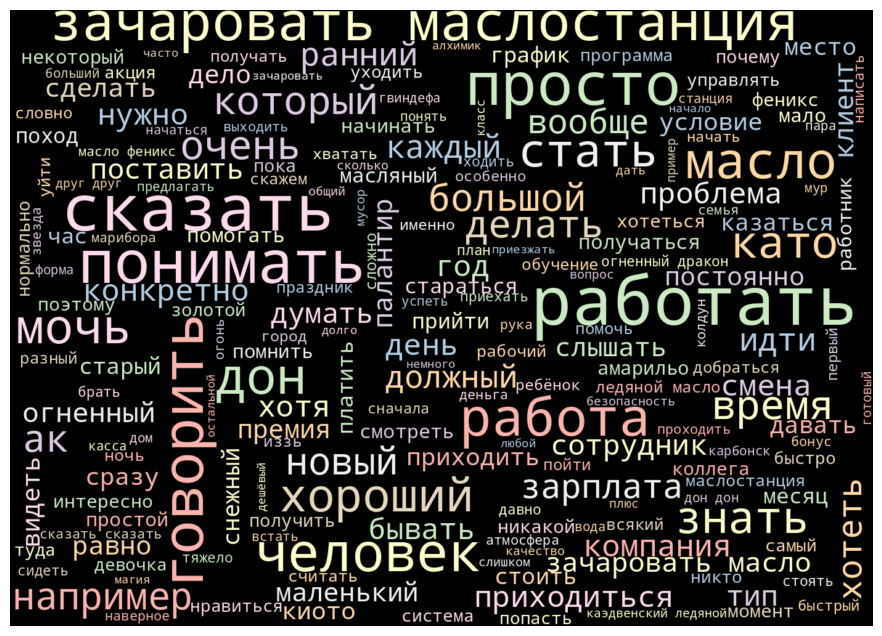

In [ ]:
text = ' '.join(df_preprocessed['processed_quote'])
wordcloud = WordCloud(width=1400, height=1000, background_color ='black', colormap='Pastel1', max_font_size=110, collocations=True).generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Можно заметить, что частота слов немного "выровнялась" — в облаке больше более крупных слов.

Однако видно, что не все самые популярные слова информативны. Несмотря на это, по менее популярным словам все еще можно судить о темах. В общем и целом, темы сохранились. Также можно выделить слова "алхимик" (работа с маслом — защита от запаха, обучение, качество масла), "клиент", которые описывают портреты социальных групп. Клиенты являются внешними участниками интервью, однако некоторые цитаты позволяют выявить узкие места в распределении зачарованного масла (сервис, цены), про клиентов в основном говорят работники ЗМС, которые указывают в своих интервью на ряд специфических проблем: взаимодействие с клиентами, работа за кассой, акции и скидки, проходимость.

Кроме того, можно заметить бессмысленные слова "киото", "като", "иззь", которые являются следствием применения SpellChecker к словам "кто-то", "как-то", "из-за" (возможно, из-за предварительного удаления дефисов в этих словах).

In [ ]:
# print(df_preprocessed[df_preprocessed['processed_quote'].str.contains('алхимик')]['quote'].values)

#### Построение модели для тематического моделирования

##### Векторизация текстов

Для применения моделей машинного обучения, необходимо получить объекты выборки, которые описываются числами, а не словами, т.е. векторизовать полученные в ходе обработки текстовые данные. Для этого можно использовать, например, Bag-of-words или TF-IDF.

**Bag-of-words**

Пусть имеется коллекция текстов $D = \{d_i\}_{i=1}^l$ и словарь всех слов, встречающихся в выборке $V = \{v_j\}_{j=1}^d.$ В этом случае некоторый текст $d_i$ описывается вектором $(x_{ij})_{j=1}^d,$ где
$$x_{ij} = \sum_{v \in d_i} [v = v_j].$$

Таким образом, текст $d_i$ описывается вектором количества вхождений каждого слова из словаря в данный текст.

**TF-IDF**

Если слово часто встречается в одном тексте, но почти не встречается в других, то оно получает для данного текста большой вес, ровно так же, как и слова, которые часто встречаются в каждом тексте. Для того чтобы разделять такие слова, можно использовать статистическую меру TF-IDF, характеризующую важность слова для конкретного текста. Для каждого слова из текста $d$ рассчитывается относительная частота встречаемости в нем (Term Frequency):
$$
\text{TF}(t, d) = \frac{C(t | d)}{\sum\limits_{k \in d}C(k | d)},
$$
где $C(t | d)$ - число вхождений слова $t$ в текст $d$.

Также для каждого слова из текста $d$ рассчитывается обратная частота встречаемости в корпусе текстов $D$ (Inverse Document Frequency):
$$
\text{IDF}(t, D) = \log\left(\frac{|D|}{|\{d_i \in D \mid t \in d_i\}|}\right)
$$
Логарифмирование здесь проводится с целью уменьшить масштаб весов, т.к. зачастую в корпусах присутствует очень много текстов.

В итоге каждому слову $t$ из текста $d$ теперь можно присвоить вес:
$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$
Интерпретация формулы выше: чем чаще данное слово встречается в данном тексте и чем реже в остальных, тем важнее оно для этого текста.

В данной задаче кажется более разумным использовать TF-IDF, т.к. необходимо выделить тематики и ключевые слова для каждой из них, поэтому нужно чтобы у слов, которые часто встречаются в текстах, соответствующих одной тематике, вес был больший.

Применение векторизатора вместе с кастомным токенизатором

In [ ]:
tfidf_vec = TfidfVectorizer(min_df=15, max_df=0.8)
X = tfidf_vec.fit_transform(df_preprocessed['processed_quote'])

- `max_df` используется для уменьшения размера матрицы за счет отбрасывания значений df близких к единице. Скорее всего, такие слова не несут много информации о категории, т.к. встречаются достаточно часто.
- `min_df` используется для уменьшения размера матрицы удалением слов со слишком маленьким df (игнорирование слов, входящих меньше чем в определенное количество документов). Такие слова тоже могут не нести в себе полезной информации, т.к. либо это слова с опечатками, которые не были исправлены в результате предобработки, либо слова, которые вряд ли характеризуют тему, общую для нескольких документов (поскольку не встречаются во всех документах данной темы).

Посмотрим на словарь, полученный в результате векторизации:

In [ ]:
print(tfidf_vec.vocabulary_)

{'ночь': 110, 'час': 219, 'первый': 122, 'като': 66, 'должный': 43, 'пара': 121, 'программа': 155, 'хотеть': 214, 'нужно': 112, 'сотрудник': 191, 'например': 100, 'город': 29, 'зачаровать': 52, 'маслостанция': 89, 'человек': 222, 'готовый': 30, 'никто': 107, 'помочь': 134, 'друг': 47, 'ранний': 169, 'хороший': 213, 'работать': 164, 'тип': 202, 'ждать': 50, 'думать': 48, 'огненный': 115, 'огонь': 116, 'давно': 33, 'просто': 158, 'искать': 61, 'приходиться': 153, 'место': 92, 'рука': 172, 'стать': 197, 'мочь': 96, 'киото': 69, 'коллега': 72, 'масло': 88, 'разный': 168, 'дракон': 46, 'простой': 159, 'дешёвый': 40, 'время': 20, 'новый': 108, 'уходить': 209, 'технология': 201, 'станция': 194, 'попасть': 138, 'говорить': 26, 'условие': 207, 'зарплата': 51, 'общий': 114, 'любой': 82, 'знать': 55, 'пока': 128, 'никакой': 106, 'нормально': 109, 'бывать': 13, 'хотеться': 215, 'иззь': 58, 'платить': 124, 'самый': 173, 'равно': 167, 'снежный': 190, 'королева': 76, 'вообще': 18, 'быстро': 14, 'стоя

Конечно, можно заметить, что в словаре остались некоторые слова с опечатками ('оттмечать', 'сттеклять'). Но в общем и целом, большая часть слов была приведена к нормальному виду. С такими данными уже можно работать.

##### Автоматическая суммаризация текстов

In [ ]:
# функция для выделения наиболее "значимых" предложений из всех предложений, относящихся к одной теме
# Экстрактивная суммаризация
def summarize_topic(text, num_sentences=1):
    parser = PlaintextParser.from_string(text, Tokenizer("russian"))
    summarizer = LuhnSummarizer(Stemmer("russian"))
    summary = summarizer(parser.document, num_sentences)
    return ' '.join(str(sentence) for sentence in summary)

##### Кластеризация при помощи KMeans

Применим сначала KMeans для простой кластеризации текстов (начальной оценки структуры данных).

In [ ]:
# кластеризация с использованием KMeans
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# получение меток кластеров
labels = kmeans.labels_

# получение ключевых слов для каждого кластера
words = tfidf_vec.get_feature_names_out()
cluster_keywords = {}
for i in range(num_clusters):
    cluster_words = [words[ind] for ind in kmeans.cluster_centers_.argsort()[:, ::-1][i, :10]]
    cluster_keywords[i] = ', '.join(cluster_words)
    print(f"Кластер {i + 1}: {', '.join(cluster_words)}")

# добавление меток кластеров и ключевых слов в датафрейм
df_topics_kmeans = df_preprocessed.copy()
df_topics_kmeans['cluster'] = labels
df_topics_kmeans['keywords'] = df_topics_kmeans['cluster'].map(cluster_keywords)

Кластер 1: уходить, год, работа, хотеть, поэтому, место, стать, иззь, давно, клиент
Кластер 2: понимать, маслостанция, зачаровать, работать, работа, масло, человек, время, знать, каждый
Кластер 3: просто, масло, сколько, попасть, видеть, проблема, хотеть, который, мочь, работа
Кластер 4: остальной, пример, немного, начинать, стоить, идти, например, стать, очень, который
Кластер 5: ак, масло, просто, зачаровать, масляный, работа, помочь, хороший, никакой, например
Кластер 6: стать, просто, делать, поставить, пора, работать, работа, маленький, зарплата, новый
Кластер 7: работать, марибора, всякий, безопасность, давно, снежный, огненный, большой, като, стать
Кластер 8: дон, должный, стать, като, долго, надеяться, масло, честно, просто, работа
Кластер 9: понимать, хороший, новый, колдун, условие, палантир, нужно, давать, приходиться, говорить
Кластер 10: добраться, сказать, туда, очень, амарильо, зарплата, график, вообще, просто, честно
Кластер 11: тип, компания, ранний, маслостанция, зача

In [ ]:
# создание кратких описаний для каждого кластера
cluster_summaries = {}
for cluster, group in df_topics_kmeans.groupby('cluster'):
    # объединение всех текстов в группе в один большой текст
    cluster_text = ' '.join(group['quote'])
    # применение метода суммаризации
    cluster_summaries[cluster] = summarize_topic(cluster_text)
df_topics_kmeans['summary'] = df_topics_kmeans['cluster'].map(cluster_summaries)

In [ ]:
df_topics_kmeans.head()

,id,quote,processed_quote,cluster,keywords,summary
0,0,«У ннас среди ночi в райооне 55 часов упала по...,среди ночь район час упасть пол вода сттеклять...,16,"като, масло, например, маслостанция, хватать, ...","Вроде бы и неплохо, что ЦМФ заботится о здрави..."
1,1,Программы повышения квалификации через гильдию...,программа повышение квалификация гильдия хитры...,18,"работать, просто, человек, масло, работа, мочь...","«Я начала об этом задумываться не так давно, в..."
2,2,"""Мурр... Новиград - город контрастов, да. Но в...",мур новиград город контраст зачаровать маслост...,14,"зачаровать, маслостанция, масло, просто, работ...","«На моём примере, получилось так, что с предыд..."
3,3,"Типа, вот уже полгода, как мы ждем установки э...",тип полгода ждать установить фильм маслобаза д...,10,"тип, компания, ранний, маслостанция, зачароват...","В других компаниях, типа ""Арефал"" или ""Ламия"",..."
4,4,"""Теперь всьё так просто! Раньше бумажки летали...",просто ранний бумага деталь теряться искать пр...,5,"стать, просто, делать, поставить, пора, работа...","Как бы, как будто их что-то мучает, как бы... ..."


In [ ]:
df_topics_kmeans['cluster'] = df_topics_kmeans['cluster'].astype('category')
df_topics_kmeans['cluster'].dtypes

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                  18, 19],
, ordered=False, categories_dtype=int32)

In [ ]:
# получение расстояний от каждого документа до центров кластеров
distances_to_centroids = kmeans.transform(X)

# применение t-SNE для уменьшения размерности до двух измерений
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(distances_to_centroids)

# добавление координат t-SNE в датафрейм
df_topics_kmeans['x_tsne'] = tsne_embeddings[:, 0]
df_topics_kmeans['y_tsne'] = tsne_embeddings[:, 1]

In [ ]:
colors = ['Crimson', 'DeepPink', 'PaleVioletRed', 'LightSalmon', 'OrangeRed', 'Yellow', 'Khaki', 'Thistle', 'Fuchsia', 'SlateBlue',
          'SaddleBrown', 'DarkOrange', 'Blue', 'Aquamarine', 'MediumSeaGreen', 'Lime', 'PaleGreen', 'DarkCyan', 'LightSteelBlue', 'Purple']

fig = px.scatter(df_topics_kmeans,
                 x='x_tsne',
                 y='y_tsne',
                 color='cluster',
                 color_discrete_sequence=colors,
                 hover_data=['keywords'],
                 title="Визуализация кластеров KMeans с использованием t-SNE",
                 labels={'x_tsne': 'X t-SNE', 'y_tsne': 'Y t-SNE'})

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    width=1300,
    height=800,
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF'),
    showlegend=True
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='grey', zeroline=False)
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='grey', zeroline=False)

fig.show()

![Визуализация кластеров KMeans](figures/kmeans_clusters.png)

Метод KMeans имеет ряд недостатков:

1) KMeans предполагает, что все кластеры имеют сферическую форму и одинаковый размер. Это может быть проблемой, если реальные темы в тексте имеют сложную структуру или сильно различаются по размеру.

2) В отличие от вероятностных моделей, таких как LDA (Latent Dirichlet Allocation), KMeans не предоставляет информацию о вероятности того, что документ относится к определенной теме.

Поэтому для тематического моделирования лучше использовать LDA.

##### Применение Latent Dirichlet Allocation (LDA)

Один из наиболее популярных методов тематического моделирования, вероятностная модель. Она основана на предположении, что каждый документ может быть представлен как смесь различных тем, а каждая тема связана с распределением слов.

In [ ]:
# применение LDA
num_topics = 20
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# вывод тем и связанных с ними слов
topic_keywords = {}
for topic_idx, topic_words in enumerate(lda.components_):
    top_words_idx = topic_words.argsort()[-10:][::-1]
    top_words = [tfidf_vec.get_feature_names_out()[i] for i in top_words_idx]
    topic_keywords[topic_idx] = ', '.join(top_words)
    print(f"Тема {topic_idx + 1}: {', '.join(top_words)}")

# добавление тематик и ключевых слов в датафрейм
df_topics_lda = df_preprocessed.copy()
df_topics_lda['topic'] = lda.transform(X).argmax(axis=1)
df_topics_lda['keywords'] = df_topics_lda['topic'].map(topic_keywords)

Тема 1: дон, ак, гвиндефа, постоянно, самый, приходиться, помнить, новый, аллах, коллега
Тема 2: сказать, ребёнок, гном, год, давать, сделать, работать, говорить, прийти, мазеть
Тема 3: стать, ак, просто, масляный, рука, красный, масло, маленький, хороший, время
Тема 4: смена, киото, мочь, коллега, программа, помочь, приехать, работать, сказать, график
Тема 5: амарильо, продажа, еда, просто, маслостанция, пойти, огненный, зачаровать, пример, хотеть
Тема 6: нравиться, план, делать, добраться, говорить, очень, приходить, идти, дом, час
Тема 7: конкретно, день, праздник, начинать, рождение, като, например, каждый, старый, рабочий
Тема 8: палантир, работать, нужно, знать, попасть, первый, работа, человек, снежный, который
Тема 9: като, хороший, поход, условие, зачаровать, маслостанция, огненный, зарплата, марибора, масло
Тема 10: премия, квартал, говорить, работать, зарплата, получить, маленький, прошлый, честно, като
Тема 11: хотеться, ночь, работа, мало, алхимик, поэтому, написать, момен

Далее визуализируем полученные кластеры при помощи техники нелинейного снижения размерности t-SNE для отображения полученных тематических векторов в двухмерное пространство.

In [ ]:
df_topics_lda['topic'] = df_topics_lda['topic'].astype('category')
df_topics_lda['topic'].dtypes

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                  18, 19],
, ordered=False, categories_dtype=int64)

In [ ]:
# получение массива вероятностей принадлежности к каждой теме для каждого документа
doc_topic_dists = lda.transform(X)

# применение t-SNE для уменьшения размерности до двух измерений
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(doc_topic_dists)

# добавление координат t-SNE в датафрейм
df_topics_lda['x_tsne'] = tsne_embeddings[:, 0]
df_topics_lda['y_tsne'] = tsne_embeddings[:, 1]

In [ ]:
colors = ['Crimson', 'DeepPink', 'PaleVioletRed', 'LightSalmon', 'OrangeRed', 'Yellow', 'Khaki', 'Thistle', 'Fuchsia', 'SlateBlue',
          'SaddleBrown', 'DarkOrange', 'Blue', 'Aquamarine', 'MediumSeaGreen', 'Lime', 'PaleGreen', 'DarkCyan', 'LightSteelBlue', 'Purple']

fig = px.scatter(df_topics_lda,
                 x='x_tsne',
                 y='y_tsne',
                 color='topic',
                 color_discrete_sequence=colors,
                 hover_data=['keywords'],
                 title="Визуализация тем LDA с использованием t-SNE",
                 labels={'x_tsne': 'X t-SNE', 'y_tsne': 'Y t-SNE'})

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    width=1300,
    height=800,
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF'),
    showlegend=True
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='grey', zeroline=False)
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='grey', zeroline=False)

fig.show()

![Визуализация тем LDA](figures/lda_topics.png)

Анализ построенной диаграммы рассеяния позволяет сделать вывод о том, что модель LDA в целом неплохо выделила темы (кластеры четко выделены и почти не накладываются друг на друга), однако кое-где видны отдельные точки, примкнувшие к кластеру не своего цвета, а также, например, темы 5, 17, 10 и кусочки тем 1 и 11 соединены друг с другом. Кроме того, можно заметить разный размер кластеров, что указывает на то, что некоторые темы (меньший размер кластера) менее популярны.

In [ ]:
df_topics_lda = df_topics_lda.drop(['x_tsne', 'y_tsne'], axis=1)

Оценим теперь распределение цитат по полученным темам.

In [ ]:
# количество цитат по каждой теме
topic_counts = df_topics_lda['topic'].value_counts().sort_index().reset_index()
topic_counts['keywords'] = topic_counts['topic'].map(topic_keywords)

fig = px.bar(
    topic_counts,
    x='topic',
    y='count',
    color_discrete_sequence=['#7BECF7'],
    hover_data=['keywords'],
    title='Количество цитат по темам',
    labels={'x': 'Темы', 'y': 'Количество цитат'}
)

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    width=1300,
    height=500,
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF'),
    xaxis_tickmode="array",
    xaxis_tickvals=list(range(len(topic_counts))),
    xaxis_ticktext=topic_counts['topic'],
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')

fig.show()

![Количество цитат по темам](figures/quotes_topics.png)

Распределение тем неравномерно, что свидетельствует о том, что одни темы более распространены, чем другие.

Также создадим краткие описания каждой темы для удобства интерпретации полученных результатов.

In [ ]:
# создание кратких описаний для каждой темы на основе экстрактивного метода суммаризации
topic_summaries = {}
for topic, group in df_topics_lda.groupby('topic'):
    # объединение всех текстов в группе в один большой текст
    topic_text = ' '.join(group['quote'])
    topic_summaries[topic] = summarize_topic(topic_text)
df_topics_lda['summary'] = df_topics_lda['topic'].map(topic_summaries)

In [ ]:
df_topics_lda.head()

,id,quote,processed_quote,topic,keywords,summary
0,0,«У ннас среди ночi в райооне 55 часов упала по...,среди ночь район час упасть пол вода сттеклять...,19,"тип, золотой, колдун, некоторый, зачаровать, м...",Я говорю «должна же быть какая-то последовател...
1,1,Программы повышения квалификации через гильдию...,программа повышение квалификация гильдия хитры...,13,"технология, хороший, сотрудник, новый, система...","Новая витрина тоже в четыре выкладывается, всё..."
2,2,"""Мурр... Новиград - город контрастов, да. Но в...",мур новиград город контраст зачаровать маслост...,11,"друг, работа, работать, быстрый, понимать, пом...","Мы понимаем, что у нас, например, кафе — это о..."
3,3,"Типа, вот уже полгода, как мы ждем установки э...",тип полгода ждать установить фильм маслобаза д...,19,"тип, золотой, колдун, некоторый, зачаровать, м...",Я говорю «должна же быть какая-то последовател...
4,4,"""Теперь всьё так просто! Раньше бумажки летали...",просто ранний бумага деталь теряться искать пр...,17,"понимать, говорить, зачаровать, человек, масло...","777 «Очень тяжело по поводу принятия актов, мы..."


Для создания системы для обработки новых цитат может понадобиться создать базу данных для хранения и последующего использования уже извлеченных тем и тегов. В данном случае в качестве БД буду использовать сам датафрейм.

In [ ]:
df_topics_lda.to_csv('df_topics_lda.csv', index=False)

В список стоп-слов nltk включается частица «не». Удаление её сильно меняет всю семантику. Поэтому проведем эксперимент, сохранив ее.

In [ ]:
stop_words.remove('не')

In [ ]:
# # чтобы не ждать пока все данные обработаются, можно просто считать предобработанные данные, которые лежат на гитхабе
# # применение токенизации к данным
# df_preprocessed['tokens_with_не'] = df_preprocessed['quote'].apply(custom_tokenizer)

# # преобразование токенов обратно в строки
# df_preprocessed['processed_quote_with_не'] = df_preprocessed['tokens_with_не'].apply(lambda x: ' '.join(x))

In [ ]:
# df_preprocessed = df_preprocessed.drop(['tokens_with_не'], axis=1)

In [ ]:
# df_preprocessed.to_csv('df_preprocessed.csv', index=False)

In [ ]:
df_preprocessed = pd.read_csv('df_preprocessed.csv')

In [ ]:
df_preprocessed.head()

,id,quote,processed_quote,processed_quote_with_не
0,0,«У ннас среди ночi в райооне 55 часов упала по...,среди ночь район час упасть пол вода сттеклять...,среди ночь район час упасть пол вода сттеклять...
1,1,Программы повышения квалификации через гильдию...,программа повышение квалификация гильдия хитры...,программа повышение квалификация гильдия хитры...
2,2,"""Мурр... Новиград - город контрастов, да. Но в...",мур новиград город контраст зачаровать маслост...,мур новиград город контраст зачаровать маслост...
3,3,"Типа, вот уже полгода, как мы ждем установки э...",тип полгода ждать установить фильм маслобаза д...,тип полгода ждать установить фильм маслобаза д...
4,4,"""Теперь всьё так просто! Раньше бумажки летали...",просто ранний бумага деталь теряться искать пр...,просто ранний бумага деталь теряться искать пр...


Теперь проведем эксперимент на предобработанных цитатах, содержащих частицу "не".

In [ ]:
# применение векторизатора вместе с кастомным токенизатором
tfidf_vec = TfidfVectorizer(min_df=15, max_df=0.8)
X = tfidf_vec.fit_transform(df_preprocessed['processed_quote_with_не'])

# посмотрим на словарь, полученный в результате векторизации
print(tfidf_vec.vocabulary_)
print()

# применение LDA
num_topics = 20
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# вывод тем и связанных с ними слов
topic_keywords = {}
for topic_idx, topic_words in enumerate(lda.components_):
    top_words_idx = topic_words.argsort()[-10:][::-1]
    top_words = [tfidf_vec.get_feature_names_out()[i] for i in top_words_idx]
    topic_keywords[topic_idx] = ', '.join(top_words)
    print(f"Тема {topic_idx + 1}: {', '.join(top_words)}")

# добавление тематик и ключевых слов в датафрейм
df_topics_lda = df_preprocessed.copy()
df_topics_lda['topic'] = lda.transform(X).argmax(axis=1)
df_topics_lda['keywords'] = df_topics_lda['topic'].map(topic_keywords)

{'ночь': 111, 'час': 220, 'не': 104, 'первый': 123, 'като': 66, 'должный': 43, 'пара': 122, 'программа': 156, 'хотеть': 215, 'нужно': 113, 'сотрудник': 192, 'например': 100, 'город': 29, 'зачаровать': 52, 'маслостанция': 89, 'человек': 223, 'готовый': 30, 'никто': 108, 'помочь': 135, 'друг': 47, 'ранний': 170, 'хороший': 214, 'работать': 165, 'тип': 203, 'ждать': 50, 'думать': 48, 'огненный': 116, 'огонь': 117, 'давно': 33, 'просто': 159, 'искать': 61, 'приходиться': 154, 'место': 92, 'рука': 173, 'стать': 198, 'мочь': 96, 'киото': 69, 'коллега': 72, 'масло': 88, 'разный': 169, 'дракон': 46, 'простой': 160, 'дешёвый': 40, 'время': 20, 'новый': 109, 'уходить': 210, 'технология': 202, 'станция': 195, 'попасть': 139, 'говорить': 26, 'условие': 208, 'зарплата': 51, 'общий': 115, 'любой': 82, 'знать': 55, 'пока': 129, 'никакой': 107, 'нормально': 110, 'бывать': 13, 'хотеться': 216, 'иззь': 58, 'платить': 125, 'самый': 174, 'равно': 168, 'снежный': 191, 'королева': 76, 'вообще': 18, 'быстро'

In [ ]:
# визуализация полученных кластеров
df_topics_lda['topic'] = df_topics_lda['topic'].astype('category')
df_topics_lda['topic'].dtypes

# получение массива вероятностей принадлежности к каждой теме для каждого документа
doc_topic_dists = lda.transform(X)

# применение t-SNE для уменьшения размерности до двух измерений
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(doc_topic_dists)

# добавление координат t-SNE в датафрейм
df_topics_lda['x_tsne'] = tsne_embeddings[:, 0]
df_topics_lda['y_tsne'] = tsne_embeddings[:, 1]

colors = ['Crimson', 'DeepPink', 'PaleVioletRed', 'LightSalmon', 'OrangeRed', 'Yellow', 'Khaki', 'Thistle', 'Fuchsia', 'SlateBlue',
          'SaddleBrown', 'DarkOrange', 'Blue', 'Aquamarine', 'MediumSeaGreen', 'Lime', 'PaleGreen', 'DarkCyan', 'LightSteelBlue', 'Purple']

fig = px.scatter(df_topics_lda,
                 x='x_tsne',
                 y='y_tsne',
                 color='topic',
                 color_discrete_sequence=colors,
                 hover_data=['keywords'],
                 title="Визуализация тем LDA с использованием t-SNE",
                 labels={'x_tsne': 'X t-SNE', 'y_tsne': 'Y t-SNE'})

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    width=1300,
    height=800,
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF'),
    showlegend=True
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='grey', zeroline=False)
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='grey', zeroline=False)

fig.show()

df_topics_lda = df_topics_lda.drop(['x_tsne', 'y_tsne'], axis=1)

![Визуализация тем LDA с частицей "не"](figures/lda_topics_with_не.png)

Исходя из анализа диаграммы рассеяния можно сказать, что выделенные кластеры лучше отделены друг от друга (расстояние между кластерами увеличилось). Распределение тем стало более равновмерным, за исключением одной, выбивающейся из общей картины (14 тема).

In [ ]:
# количество цитат по каждой теме
topic_counts = df_topics_lda['topic'].value_counts().sort_index().reset_index()
topic_counts['keywords'] = topic_counts['topic'].map(topic_keywords)

fig = px.bar(
    topic_counts,
    x='topic',
    y='count',
    color_discrete_sequence=['#7BECF7'],
    hover_data=['keywords'],
    title='Количество цитат по темам',
    labels={'x': 'Темы', 'y': 'Количество цитат'}
)

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    width=1300,
    height=500,
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(color='#FFFFFF'),
    xaxis_tickmode="array",
    xaxis_tickvals=list(range(len(topic_counts))),
    xaxis_ticktext=topic_counts['topic'],
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')

fig.show()

![Количество цитат по темам с частицей "не"](figures/quotes_topics_with_не.png)

In [ ]:
# создание кратких описаний для каждой темы на основе экстрактивного метода суммаризации
topic_summaries = {}
for topic, group in df_topics_lda.groupby('topic'):
    # объединение всех текстов в группе в один большой текст
    topic_text = ' '.join(group['quote'])
    topic_summaries[topic] = summarize_topic(topic_text)
df_topics_lda['summary'] = df_topics_lda['topic'].map(topic_summaries)

In [ ]:
df_topics_lda = df_topics_lda.drop(['processed_quote'], axis=1)
df_topics_lda.head()

,id,quote,processed_quote_with_не,topic,keywords,summary
0,0,«У ннас среди ночi в райооне 55 часов упала по...,среди ночь район час упасть пол вода сттеклять...,6,"новый, не, колдун, место, поставить, получать,...",Я говорю «должна же быть какая-то последовател...
1,1,Программы повышения квалификации через гильдию...,программа повышение квалификация гильдия хитры...,19,"система, масло, огненный, сотрудник, например,...","«На моём примере, получилось так, что с предыд..."
2,2,"""Мурр... Новиград - город контрастов, да. Но в...",мур новиград город контраст зачаровать маслост...,1,"дон, амарильо, больший, гвиндефа, дешёвый, кош...","Некоторые представлляют, что онни будуть, прих..."
3,3,"Типа, вот уже полгода, как мы ждем установки э...",тип полгода ждать установить фильм маслобаза д...,19,"система, масло, огненный, сотрудник, например,...","«На моём примере, получилось так, что с предыд..."
4,4,"""Теперь всьё так просто! Раньше бумажки летали...",просто ранний бумага деталь теряться искать пр...,6,"новый, не, колдун, место, поставить, получать,...",Я говорю «должна же быть какая-то последовател...


In [ ]:
df_topics_lda.to_csv('df_topics_lda.csv', index=False)

Сохранение векторизатора и модели для дальнейшего использования на новых цитатах

In [ ]:
# сохранение векторизатора
pkl_filename = "./tfidf_vec.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(tfidf_vec, file)

In [ ]:
# сохранение модели LDA
pkl_filename = "./model_lda.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lda, file)

#### Тематическое моделирование при помощи BERTopic

Так как BERTopic основан на трансформерной модели, которая учитывает контекстуальные зависимости между словами и их семантические связи, поэтому для данной модели тематического моделирования не требуется лемматизация данных.

In [ ]:
def custom_tokenizer_for_bertopic(s: str) -> List[str]:
    # Кастомный токенизатор

    # приведение строки к нижнему регистру
    s = s.lower()
    # удаление всех мусорных символов, в т.ч. пунктуации
    s = re.sub('[^а-яa-z0-9 ]', '', s)
    # токенизация строки на слова
    s = word_tokenize(s)

    mask = list(map(word_is_digit, s))
    # маска, определяющая слова из списка, состоящие только из цифр
    s = np.array(s)[np.where(np.array(mask)==0)].tolist()
    # оставляю список из слов, не удовлетворяющих условию (маске), т.е. слов не состоящих только из цифр

    # исправление опечаток в словах
    s = [correct_spelling(word) for word in s]

    # удаление цифр внутри слов
    s = [delete_digits_in_word(word) for word in s]

    # проверка, является ли слово стоп-словом
    def is_a_stop_word(w: str):
      return pymorphy2_analyzer.parse(w)[0].normal_form in stop_words

    stop_word_mask = list(map(is_a_stop_word, s))
    # применяю маску ко всему списку, чтобы определить, какие слова из списка являются стоп-словами
    s = np.array(s)[np.where(np.array(stop_word_mask)==0)].tolist()
    # оставляю только слова, не удовлетворяющие условию (маске), т.е. те, которые не являются стоп-словами
    return s

In [ ]:
# df_preprocessed['tokens_for_bertopic'] = df_preprocessed['quote'].apply(custom_tokenizer_for_bertopic)

# df_preprocessed['processed_quote_for_bertopic'] = df_preprocessed['tokens_for_bertopic'].apply(lambda x: ' '.join(x))

In [ ]:
# df_preprocessed = df_preprocessed.drop(['tokens_for_bertopic'], axis=1)

In [ ]:
# df_preprocessed.to_csv('df_preprocessed.csv', index=False)

In [ ]:
df_preprocessed = pd.read_csv('df_preprocessed.csv')

In [ ]:
df_preprocessed.head()

,id,quote,processed_quote,processed_quote_with_не,processed_quote_for_bertopic
0,0,«У ннас среди ночi в райооне 55 часов упала по...,среди ночь район час упасть пол вода сттеклять...,среди ночь район час упасть пол вода сттеклять...,среди ночь районе часов упала пола водой сттек...
1,1,Программы повышения квалификации через гильдию...,программа повышение квалификация гильдия хитры...,программа повышение квалификация гильдия хитры...,программы повышение квалификации гильдии хитры...
2,2,"""Мурр... Новиград - город контрастов, да. Но в...",мур новиград город контраст зачаровать маслост...,мур новиград город контраст зачаровать маслост...,мур новиград город контрастов зачарованная мас...
3,3,"Типа, вот уже полгода, как мы ждем установки э...",тип полгода ждать установить фильм маслобаза д...,тип полгода ждать установить фильм маслобаза д...,типа полгода ждем установи фильмов маслобазе д...
4,4,"""Теперь всьё так просто! Раньше бумажки летали...",просто ранний бумага деталь теряться искать пр...,просто ранний бумага деталь теряться искать пр...,просто раньше бумаги детали терялись искать пр...


In [ ]:
topic_model = BERTopic(language="Russian", n_gram_range=(1, 2))
topics, probs = topic_model.fit_transform(df_preprocessed['processed_quote_for_bertopic'])

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,424,-1_не_просто_понимаешь_масло,"[не, просто, понимаешь, масло, работать, масло...",[бывает программу перегрузили черный оракул мо...
1,0,188,0_масло_зачарованная_зачарованная маслостанция...,"[масло, зачарованная, зачарованная маслостанци...",[приехал север начал работать субподрядчик каэ...
2,1,47,1_не_график_очень_смены,"[не, график, очень, смены, день, просто, ночью...",[отказывается ночной смены выделяла причины гр...
3,2,38,2_не_говорю_журнал_люди,"[не, говорю, журнал, люди, ой, управляющий, ла...",[лично коснулось негативный опыт пообщалась уп...
4,3,36,3_сказать_като_праздники_стать,"[сказать, като, праздники, стать, рождения, пр...",[праздники като като не очень организованная с...
5,4,32,4_дракон_огненный_просто_огненный дракон,"[дракон, огненный, просто, огненный дракон, ко...",[гвиндефе воздух вибрирует энергии магии появи...
6,5,32,5_снежный_премии_квартал_лучше,"[снежный, премии, квартал, лучше, не, королеве...",[прошлом квартал понимаешь премии космический ...
7,6,29,6_понимаешь_масло_молодых алхимик_программа ст...,"[понимаешь, масло, молодых алхимик, программа ...",[конкретно программа стажировок молодых алхими...
8,7,22,7_дон_сказать_скажи_дон дон,"[дон, сказать, скажи, дон дон, дон не, стандар...",[вон ежемесячные обряд дон барьер дон вокруг з...
9,8,21,8_зарплата_кaчeм_дон_зарплату,"[зарплата, кaчeм, дон, зарплату, стать, роста,...",[работала огain не устроила зарплата проработа...


In [ ]:
topic_model.visualize_barchart()

![Topic Word Scores](figures/topic_word_scores.png)

In [ ]:
topic_model.visualize_topics()

<div align="center">
  <img src="figures/intertopic_dist_map.png" alt="Intertopic Distance Map" width="400" height="300">
</div>

In [ ]:
topic_model.visualize_documents(df_preprocessed['quote'])

In [ ]:
topic_model.visualize_hierarchy()


![Hierarchical Clustering](figures/hierarchical_clustering.png)

In [ ]:
df_topics_and_docs_bertopic = topic_model.get_document_info(df_preprocessed['quote'])[['Document', 'Topic', 'Name', 'Top_n_words']]
df_topics_and_docs_bertopic.to_csv('df_topics_and_docs_bertopic.csv', index=False)

In [ ]:
df_topics_bertopic = topic_model.get_topic_info()
df_topics_bertopic.to_csv('df_topics_bertopic.csv', index=False)

In [ ]:
# сохранение модели BERTopic
pkl_filename = "./model_bertopic.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(topic_model, file)

#### Система для обработки новых цитат

Для создания системы необходимо хранить информацию о ранее извлеченных темах и тегах. Для хранения данных о цитатах и их темах можно использовать локальную БД (например, SQLite или файлы CSV (как это решила делать я)). Нужна также возможность легко делать прогнозы для новых цитат. Для этого можно использовать уже обученную модель.

Каждая новая цитата должна обрабатываться аналогичным образом, как это было сделано для известных цитат. Поэтому может быть использован реализованный кастомный токенизатор.

Скрипт, который будет автоматически обрабатывать новые цитаты, используя уже накопленные данные. Векторизатор и модель используются уже обученные и сохраненные. Однако, если данные очень сильно поменяются (например, появятся новые сотрудники с совершенно другим бэкграундом, которые будут говорить по-другому, может быть с другим акцентом, своим собственным слэнгом, или вообще будут говорить на другие темы), тогда алгоритмы необходимо будет обучить заново, на всем корпусе цитат (старые + новые). В таком случае нужно будет обновить БД цитат с тематиками и ключевыми словами.

Как работает система:
1. Получает на вход пути к файлам с новыми цитатами (json файл), моделью, векторизатором, старыми цитатами (csv файл).
2. Загружает датафреймы с исходными цитатами и с новыми цитатами для обработки, а также векторизатор и модель.
3. Создает датафрейм с новыми цитатами, применяет к ним кастомный токенизатор (вместе с предобработкой), а затем векторизует.
4. Далее применяет модель и выводит результат.
5. Если необходимо обновить БД с цитатами, система также это делает.

In [ ]:
def analyze_new_interviews(new_quotes_path, model_path, df_topics_path, vectorizer_path=None, update_db=False):

    # загрузка исходного датафрейма
    df_topics = pd.read_csv(df_topics_path)

    # загрузка новых цитат
    with open(new_quotes_path) as f:
        new_quotes = json.load(f)

    # загрузка векторизатора и модели
    if vectorizer_path:
        with open(vectorizer_path, 'rb') as file:
            vectorizer = pickle.load(file)
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

    # создание датафрейма с новыми цитамами
    new_df = pd.DataFrame(new_quotes)

    if 'lda' in model_path:
        # применение кастомного токенизатора к новым данным
        new_df['tokens'] = new_df['quote'].apply(custom_tokenizer)
        # преобразование токенов обратно в строки
        new_df['processed_quote'] = new_df['tokens'].apply(lambda x: ' '.join(x))
        new_df = new_df.drop(['tokens'], axis=1)

        # векторизация новых данных
        X_new = vectorizer.transform(new_df['processed_quote'])

        # применение модели на новых данных
        new_df['topic'] = model.transform(X_new).argmax(axis=1)
        # извлечение ключевых слов для каждой темы из исходного датафрейма
        topic_keywords = df_topics.groupby('topic')['keywords'].first().to_dict()
        new_df['keywords'] = new_df['topic'].map(topic_keywords)

    elif 'bertopic' in model_path:
        # применение кастомного токенизатора к новым данным
        new_df['tokens'] = new_df['quote'].apply(custom_tokenizer_for_bertopic)
        # преобразование токенов обратно в строки
        new_df['processed_quote'] = new_df['tokens'].apply(lambda x: ' '.join(x))
        new_df = new_df.drop(['tokens'], axis=1)

        # применение модели на новых данных
        topics, _ = model.transform(new_df['processed_quote'])
        new_df['Topic'] = topics
        topic_names = df_topics.set_index('Topic')['Name'].to_dict()
        new_df['Name'] = new_df['Topic'].map(topic_names)
        topic_keywords = df_topics.set_index('Topic')['Top_n_words'].to_dict()
        new_df['Top_n_words'] = new_df['Topic'].map(topic_keywords)

    else:
        raise ValueError("Неизвестный тип модели")

    if update_db:
        if 'bertopic' in model_path:

            new_df['Document'] = new_df['quote']
            new_df = new_df.drop(['quote', 'processed_quote', 'id'], axis=1)

        # конкатенация нового датафрейма с исходным
        updated_df = pd.concat([df_topics, new_df], ignore_index=True)
        # сохранение обновленного датафрейма
        updated_df.to_csv(df_topics_path, index=False)

    return new_df

Далее можно использовать Docker для упаковки системы (скрипта), что позволит ее запускать в изолированном окружении с минимальными зависимостями, добавив в скрипт необходимые импорты и функции.

Далее при помощи LLM были сгенерированы несколько новых цитат, подобных нашим цитатам, чтобы проверить работу системы на них.

In [ ]:
new_quotes = [
    {
        "id": 959,
        "quote": "«Та же лекаркомиссия у нас за счет работодателя, очень многие хитрые люди приходят, проходят лекаркомиссию, забирают книжку и не выходят на работу вообще. Просто теряются. Человек лекаркомиссию прошел за счет работодателя, оплачивается, он же не оплатил эту лекаркомиссию» «Они (кандидаты на трудоустройство) проходят медосмотр, и там приходит результат медосмотра на почту подбора, что они прошли, их можно приглашать на трудоустройство. Человек же тоже знает, что его лекаркнижка через пять дней будет готова, люди тоже хитрые, когда девочки, которые им звонят, говорят «на пятое число, на вторник хотим вас пригласить», «ой, вы знаете, ребенок приболел, можно мне на другой день?», ты идешь на уступки, говоришь «конечно», мы входим в положение, всякое бывает в жизни. Ты говоришь «да, хорошо», а он спокойненько едет, забирает эту лекаркнижку и всё»"
    },
    {
        "id": 960,
        "quote": "Так сказать, раньше, когда мы только начинали, вот тут в Амарильо, то дни рождения коллег отмечали так сказать, скромно, по-домашнему. А сейчас, когда ЦМФ так сказать, разрослась, то вот и праздники стали масштабнее, так сказать. \n"
    },
    {
        "id": 961,
        "quote": "«ЗМС расположена на трассе А-108, ближнее население пункты далеко, омнибусы ходят очень редко, если даже кто-то едет, у нас два человека, которые ездят или на омнибусе, или на такси, перерыв между омнибусами очень большой. Они приезжают за полтора часа на работу, с работы уезжают на час-полтора позже своего времени. В основном весь персонал у нас ездит на своих автомобилях или на такси, потому что добираться очень неудобно» \n"
    }
]

with open('new_quotes.json', 'w') as f:
    json.dump(new_quotes, f)

In [ ]:
# обработка новых цитат с использованием модели LDA
new_df_lda = analyze_new_interviews('new_quotes.json', 'model_lda.pkl', 'df_topics_lda.csv', 'tfidf_vec.pkl')
new_df_lda

,id,quote,processed_quote,topic,keywords
0,959,«Та же лекаркомиссия у нас за счет работодател...,лекаркомиссия счёт работодатель очень многие х...,14,"не, очень, человек, говорить, работать, мочь, ..."
1,960,"Так сказать, раньше, когда мы только начинали,...",сказать ранний начинать амарильо день рождение...,5,"сказать, тип, праздник, день, мазеть, стать, р..."
2,961,"«ЗМС расположена на трассе А-108, ближнее насе...",расположение трасса близкий население пункт да...,14,"не, очень, человек, говорить, работать, мочь, ..."


In [ ]:
# обработка новых цитат с использованием модели BERTopic
new_df_bertopic = analyze_new_interviews('new_quotes.json', 'model_bertopic.pkl', 'df_topics_and_docs_bertopic.csv')
new_df_bertopic

,Topic,Name,Top_n_words,Document
0,-1,-1_не_просто_понимаешь_масло,не - просто - понимаешь - масло - работать - м...,«Та же лекаркомиссия у нас за счет работодател...
1,3,3_сказать_като_праздники_стать,сказать - като - праздники - стать - рождения ...,"Так сказать, раньше, когда мы только начинали,..."
2,9,9_добраться_очень_транспорт_далеко,добраться - очень - транспорт - далеко - такси...,"«ЗМС расположена на трассе А-108, ближнее насе..."


Для создания системы может понадобиться также разработать интерфейс для пользователей Йеннифер и Трисс, который позволит им загружать новые цитаты и получать для них анализ тем и тегов. Тут уже необходимо обратиться к крутым разработчикам ЦМФ!)

Ограничения и варианты решения:

- самым большим и важным ограничением является качество текста. Даже исходные цитаты не удалось обработать так, как бы хотелось (все ошибки, к сожалению, не были исправлены ввиду слишком сложной структуры ошибок). Как вариант — немного поколдовать над самопишущим цидарийским пером, чтобы оно более качественно записывало тексты цитат :))

- еще одно ограничение — из-за применения метода автоматического исправления опечаток, цитаты обрабатываются не слишком быстро. Тут мы опять возвращаемся к качеству текстов, записываемых пером. Также можно рассмотреть возможность параллельной обработки данных.

- необходимость в обновлении тематик: как я уже писала выше, если в ЦМФ появятся новые сотрудники с совершенно другим бэкграундом, то придется модели обучать заново.